In [1]:
!unzip brain_tumors.zip

Archive:  brain_tumors.zip
   creating: brain_tumors/glioma_tumor/
  inflating: brain_tumors/glioma_tumor/G_1.jpg  
  inflating: brain_tumors/glioma_tumor/G_10.jpg  
  inflating: brain_tumors/glioma_tumor/G_100.jpg  
  inflating: brain_tumors/glioma_tumor/G_101.jpg  
  inflating: brain_tumors/glioma_tumor/G_102.jpg  
  inflating: brain_tumors/glioma_tumor/G_103.jpg  
  inflating: brain_tumors/glioma_tumor/G_104.jpg  
  inflating: brain_tumors/glioma_tumor/G_105.jpg  
  inflating: brain_tumors/glioma_tumor/G_106.jpg  
  inflating: brain_tumors/glioma_tumor/G_107.jpg  
  inflating: brain_tumors/glioma_tumor/G_108.jpg  
  inflating: brain_tumors/glioma_tumor/G_109.jpg  
  inflating: brain_tumors/glioma_tumor/G_11.jpg  
  inflating: brain_tumors/glioma_tumor/G_110.jpg  
  inflating: brain_tumors/glioma_tumor/G_111.jpg  
  inflating: brain_tumors/glioma_tumor/G_112.jpg  
  inflating: brain_tumors/glioma_tumor/G_113.jpg  
  inflating: brain_tumors/glioma_tumor/G_114.jpg  
  inflating: brain_

In [2]:
!pip install tensorflow_addons
!pip install vit_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from keras.models import Model

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow_addons as tfa
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Set the seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

In [6]:
# Load the data
data_dir = 'brain_tumors'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

In [7]:
# Prepare the dataset
data = []
labels = []
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img = tf.keras.preprocessing.image.load_img(os.path.join(class_dir, img_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        data.append(img_array)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

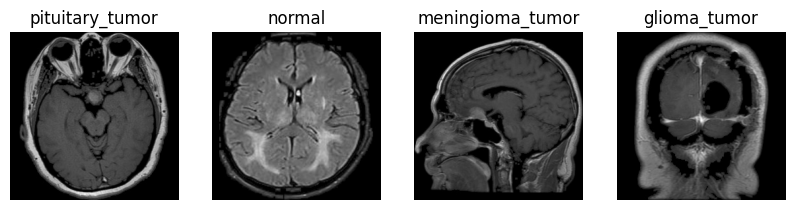

In [8]:
# Plot sample images from each class
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    sample_image = random.choice(image_files)
    sample_image_path = os.path.join(class_dir, sample_image)
    img = plt.imread(sample_image_path)
    plt.subplot(1, num_classes, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [9]:
# Print the number of images in each class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Number of images in {class_name}: {num_images}")

Number of images in pituitary_tumor: 844
Number of images in normal: 438
Number of images in meningioma_tumor: 913
Number of images in glioma_tumor: 901


In [10]:
# Split the data into training, validation, and testing sets while maintaining class proportions
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [11]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# model

In [12]:
vit_model = vit.vit_b32(
        image_size = IMG_HEIGHT,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

353253686/353253686 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [14]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(num_classes, 'softmax')
    ],
    name = 'vision_transformer')

In [15]:
# Compile the model
model.compile(optimizer=tfa.optimizers.AdamW(
                learning_rate=1e-5, weight_decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Epoch 1/20
62/62 [==============================] - 48s 444ms/step - loss: 1.3072 - accuracy: 0.4106 - val_loss: 1.1547 - val_accuracy: 0.5355
Epoch 2/20
62/62 [==============================] - 24s 390ms/step - loss: 0.9853 - accuracy: 0.6293 - val_loss: 0.8806 - val_accuracy: 0.7032
Epoch 3/20
62/62 [==============================] - 25s 399ms/step - loss: 0.7742 - accuracy: 0.7616 - val_loss: 0.6582 - val_accuracy: 0.7758
Epoch 4/20
62/62 [==============================] - 24s 394ms/step - loss: 0.6355 - accuracy: 0.8045 - val_loss: 0.5353 - val_accuracy: 0.8210
Epoch 5/20
62/62 [==============================] - 24s 392ms/step - loss: 0.5105 - accuracy: 0.8601 - val_loss: 0.4364 - val_accuracy: 0.8645
Epoch 6/20
62/62 [==============================] - 24s 394ms/step - loss: 0.4319 - accuracy: 0.8838 - val_loss: 0.3600 - val_accuracy: 0.8887
Epoch 7/20
62/62 [==============================] - 25s 397ms/step - loss: 0.3813 - accuracy: 0.9020 - val_loss: 0.3154 - val_accuracy: 0.9000

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 2s 118ms/step - loss: 0.1947 - accuracy: 0.9516
Test accuracy: 0.9516128897666931


In [18]:
# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

20/20 [==============================] - 7s 152ms/step


In [19]:
# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       169
           1       0.98      0.99      0.98        88
           2       0.91      0.93      0.92       183
           3       0.97      0.93      0.95       180

    accuracy                           0.95       620
   macro avg       0.96      0.96      0.96       620
weighted avg       0.95      0.95      0.95       620



In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[165   0   4   0]
 [  0  87   1   0]
 [  6   1 171   5]
 [  1   1  11 167]]


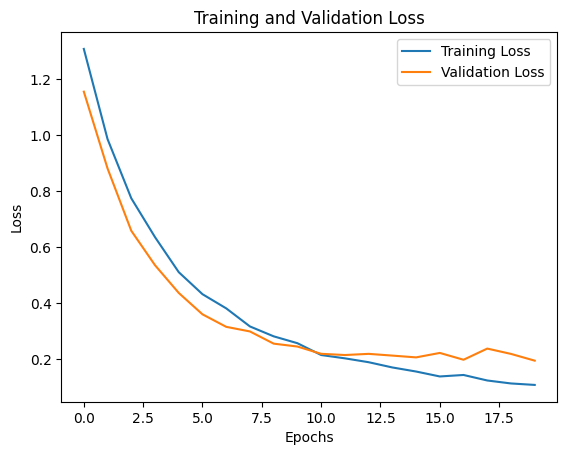

In [21]:
# Loss curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Select five random indices from the test set
random_indices = np.random.choice(len(x_test), 5, replace=False)

In [23]:
# Get the actual and predicted classes for the selected indices
actual_classes = y_test[random_indices]
predicted_classes = y_pred_classes[random_indices]

In [24]:
# Define class labels
class_labels = ["glioma_tumor", "meningioma_tumor", "normal", "pituitary_tumor"]

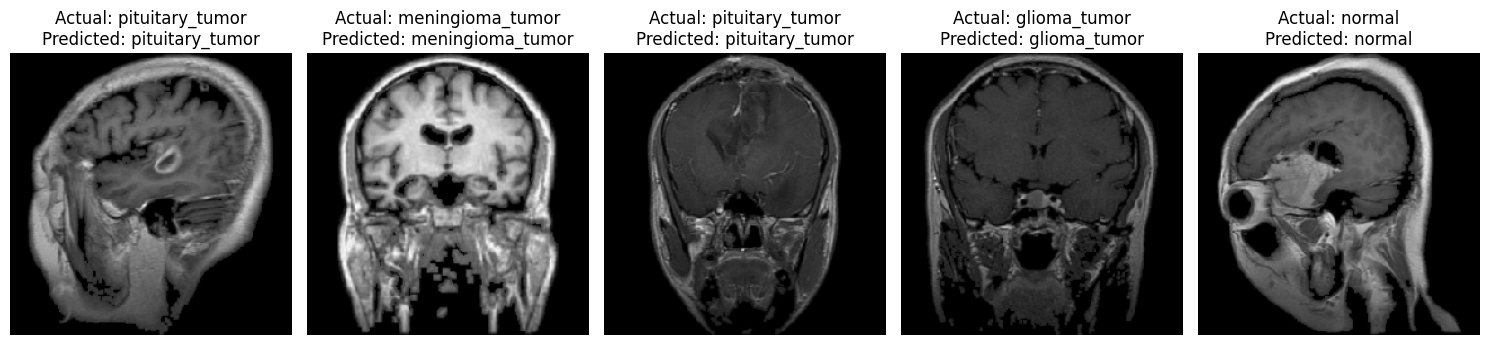

In [25]:
# Plot the images with their actual and predicted classes
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[idx])  # Assuming x_test contains the images
    plt.title(f"Actual: {class_labels[actual_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()